In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
use_neptune = False

In [4]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [52]:
generator_layers = 3
data_bus_size = 6
rank = 1
real_circuit_type = 'phase'
g_values = [-0.5]
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.ONLY_KNOWN
known_g_values = np.linspace(-1,-0.5,16)
# known_g_values = [-1, -0.75, -0.5, -0.25, 0]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 10
        hidden_dim = 32
        penalty_factor = 10
        gan_epochs = 10000
        batch_size = 4
known_g_values

array([-1.        , -0.96666667, -0.93333333, -0.9       , -0.86666667,
       -0.83333333, -0.8       , -0.76666667, -0.73333333, -0.7       ,
       -0.66666667, -0.63333333, -0.6       , -0.56666667, -0.53333333,
       -0.5       ])

In [53]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [54]:
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False, g_positive=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

In [55]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    if real_circuit_type == 'butterfly':
        gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [56]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 2): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [57]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(theta0)───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                 │                                     │
(0, 2): ────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                             │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                          │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                         │                                       │
(0, 5): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta15)───X───X───Ry(theta16)───X───Ry(theta13)───X───X───Ry(theta14)───X───

In [58]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [59]:
def get_expectation_provider():
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider,
                                                                       get_discriminator(real))
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectation_provider, gen_input_dim, hidden_dim, penalty_factor, gan_epochs, batch_size)

In [60]:
real_expectations_provider = get_expectation_provider()

In [61]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  real_expectations_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [62]:
epochs = 801
gen_iteration = 1
snapshot_interval_epochs = 100

In [63]:
def start_neptune_experiment():
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em', api_token=neptun_token)
        neptun_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs
        }
        if expectation_provider_type == ExpectationProviderType.WGAN:
            gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size
            }
            neptun_params = {**neptun_params, **gan_params}
        neptune.create_experiment(name=None, description=None, params=neptun_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [64]:
start_neptune_experiment()

<Figure size 432x288 with 0 Axes>

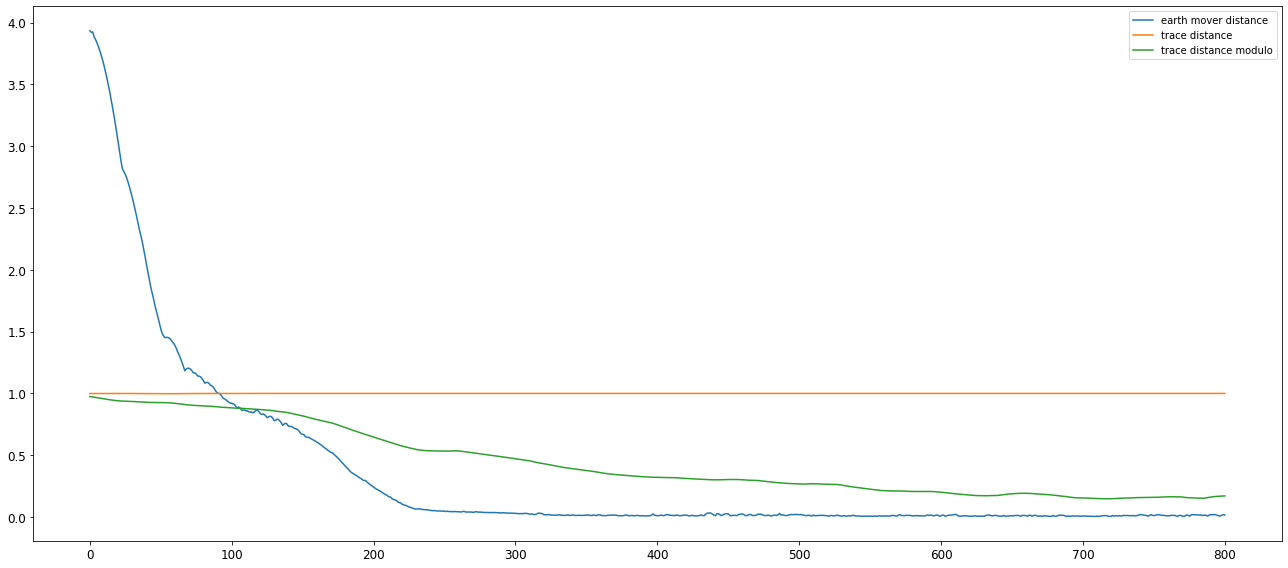

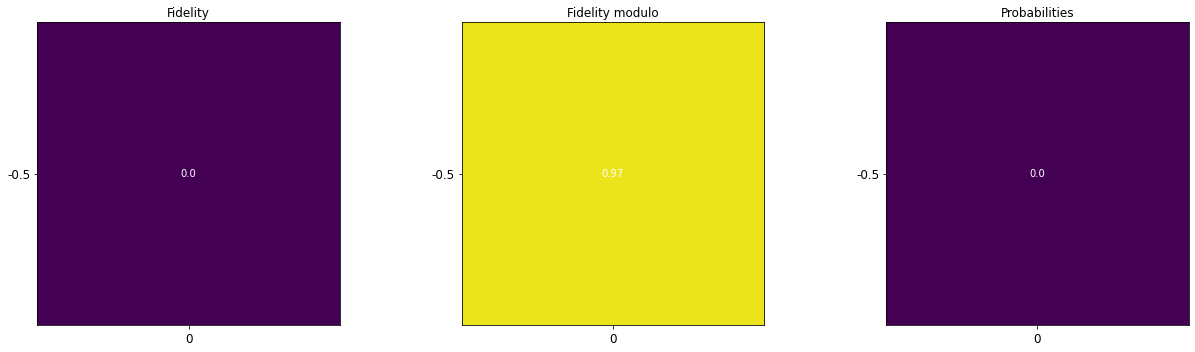

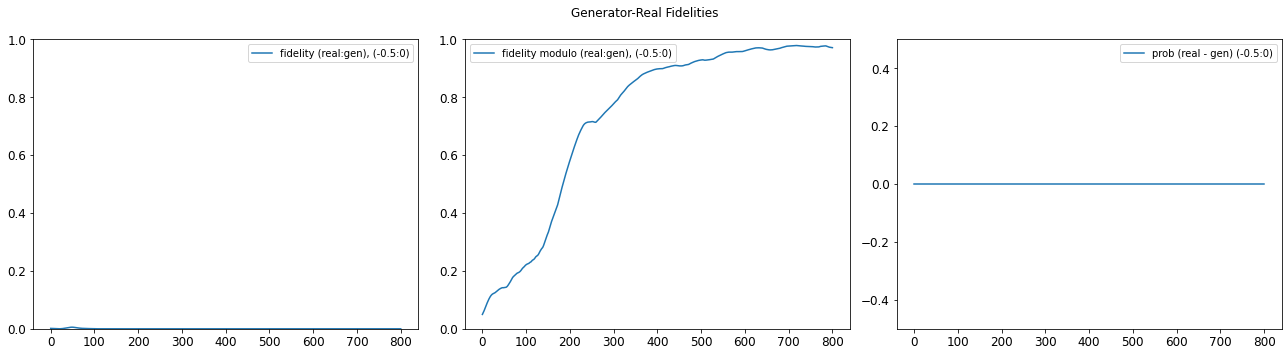

----------------------------------------------------
Epoch 800:  EM distance = 0.016259380613556997, trace distance = 1.0000003974920675, abs trace distance = 0.17088201847527199
h=X((0, 0))*Z((0, 4)), w=0.9999999633174299, e=0.0055879466235637665
h=Z((0, 1))*X((0, 2)), w=0.9999999653054948, e=0.003288380801677704
h=Z((0, 5)), w=0.9999999806261652, e=0.003855265211313963
h=Z((0, 3)), w=0.9999999788559644, e=0.003527788445353508
-------------------------------------
----------- TRAINING DONE -----------


In [65]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [162]:
np.set_printoptions(suppress=True)
def get_expectations_real(g, t):
    full_weights = tf.keras.layers.Layer()(
                tf.Variable(np.array(t.real_values_provider(g), dtype=np.float32)))
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.real_expectation([t.real],
                                         symbol_names=t.real_symbols,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_expectations_gen(g, t):
    full_weights = tf.keras.layers.Layer()(t.gen_weights[0][2])
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.gen_expectation([t.gen],
                                         symbol_names=t.gs,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_expectations(resolved_circuit, t):
    exps = t.gen_expectation([resolved_circuit], operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_filtered_expectatoins(resolved_circuit, t, eps=1e-3):
    return {pauli_string: exp for pauli_string, exp in get_expectations(resolved_circuit, t).items() if abs(float(exp)) >= eps}

def get_exps(g_list, trainer, eps=1e-3):
    res = defaultdict(list)
    for g in g_list:
        for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps):
            res[e[0]].append(e[1])
    return res

def get_exp(g, trainer, eps=1e-3):
    res_r = defaultdict(list)
    res_g = defaultdict(list)
    for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_r[e[0]].append(e[1])
    for e in (fe for fe in get_expectations_gen(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_g[e[0]].append(e[1])
    return res_r, res_g

In [163]:
def get_symbol_by_name(symbols, name):
    return next(x for x in symbols if x.name == name)

def get_symbols_to_value_mapping(symbols, names_values):
    return {get_symbol_by_name(symbols, name): value for name, value in names_values.items()}

def resolve_cricuit_with_replacement(evaluator, label, replacements_str):
    replacements = get_symbols_to_value_mapping(evaluator.symbol_value_pairs[0][2].keys(), 
                                                replacements_str)
    return evaluator.get_resolved_circuit(labels=label, symbols_to_override=replacements)


In [164]:
not_resolved_circuit = trainer.gen_evaluator.circuit
not_resolved_circuit

(0, 0): ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(theta0)───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                 │                                     │
(0, 2): ────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                             │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                          │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                         │                                       │
(0, 5): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta15)───X───X───Ry(theta16)───X───Ry(theta13)───X───X───Ry(theta14)───X───

In [165]:
resolved_circuit = trainer.gen_evaluator.get_resolved_circuit()
resolved_circuit

(0, 0): ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(0.502π)───X─────────────@───X──────────────────────────────────@───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                  │                                      │
(0, 2): ────────────────────────────Ry(-0.053π)───X───X───Ry(-0.254π)───X───Ry(0.246π)───X───X───Ry(-0.047π)───X───X─────────────@───X──────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                 │                                      │
(0, 3): ───────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(-0.053π)───X───X───Ry(-0.248π)───X───Ry(0.251π)───X───X───Ry(-0.054π)───X───X────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                               │                                      │
(0, 4): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.043π)───X───X───Ry(0.245π)───X───Ry(-0.256π)───X───X───Ry(0.05π)───X───X─────────────@───X──────────────────────────────────@───X────────────────────
                                                                                                                                                                                                                                                                                            │                                      │
(0, 5): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(-0.066π)───X───X───Ry(-0.252π)───X───Ry(0.453π)───X───X───Ry(0.999π)───X───

In [166]:
resolved_replaced_circuit = resolve_cricuit_with_replacement(
    trainer.gen_evaluator, 
    None, 
    {
        'theta13': 1.4235, 
        'theta14': 3.14
    }
)
resolved_replaced_circuit

(0, 0): ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(0.502π)───X─────────────@───X──────────────────────────────────@───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                  │                                      │
(0, 2): ────────────────────────────Ry(-0.053π)───X───X───Ry(-0.254π)───X───Ry(0.246π)───X───X───Ry(-0.047π)───X───X─────────────@───X──────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                 │                                      │
(0, 3): ───────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(-0.053π)───X───X───Ry(-0.248π)───X───Ry(0.251π)───X───X───Ry(-0.054π)───X───X────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                               │                                      │
(0, 4): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.043π)───X───X───Ry(0.245π)───X───Ry(-0.256π)───X───X───Ry(0.05π)───X───X─────────────@───X──────────────────────────────────@───X────────────────────
                                                                                                                                                                                                                                                                                            │                                      │
(0, 5): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(-0.066π)───X───X───Ry(-0.252π)───X───Ry(0.453π)───X───X───Ry(0.999π)───X───

In [167]:
get_filtered_expectatoins(resolved_replaced_circuit, trainer)

{'Z((0, 1))*X((0, 4))': 0.058502197,
 'Z((0, 1))*Z((0, 4))': 0.02933113,
 'X((0, 4))*Z((0, 5))': -0.003926903,
 'Z((0, 4))*X((0, 5))': -0.7818286,
 'Z((0, 4))*Z((0, 5))': 0.16762531,
 'Y((0, 4))*Y((0, 5))': 0.0032107122,
 'Z((0, 3))*X((0, 4))': 0.5750386,
 'Z((0, 3))*Z((0, 4))': 0.28829774,
 'X((0, 0))*X((0, 4))': -0.05850122,
 'X((0, 0))*Z((0, 4))': -0.02933062,
 'Z((0, 2))*X((0, 4))': 0.18967299,
 'Z((0, 2))*Z((0, 4))': 0.09509407,
 'Z((0, 1))*X((0, 5))': -0.02293596,
 'Z((0, 1))*Z((0, 5))': 0.0048976922,
 'Z((0, 1))*Z((0, 3))': 0.10173639,
 'X((0, 0))*Z((0, 1))': -0.99998343,
 'Z((0, 0))*Z((0, 1))': 0.0057745,
 'Z((0, 1))*X((0, 2))': 0.0032873005,
 'Z((0, 1))*Z((0, 2))': 0.30844012,
 'Z((0, 3))*X((0, 5))': -0.22588156,
 'Z((0, 3))*Z((0, 5))': 0.04606787,
 'X((0, 0))*X((0, 5))': 0.022935592,
 'X((0, 0))*Z((0, 5))': -0.004897602,
 'Z((0, 2))*X((0, 5))': -0.07446152,
 'Z((0, 2))*Z((0, 5))': 0.015404998,
 'X((0, 0))*Z((0, 3))': -0.10173467,
 'Z((0, 2))*X((0, 3))': -0.0020849556,
 'Z((0,